# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.preprocessing import ScalerWrapper
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


### Some hyper-parameters:

In [3]:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

## Air Passenger Example

In [4]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [9]:
my_model = RNNModel(
    model='LSTM',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42
)

In [10]:
my_model.fit(train_transformed, val_transformed, verbose=True)  # 107

Training loss: 0.3719, validation loss: 0.8285Training loss: 0.1135, validation loss: 0.1145Training loss: 0.0547, validation loss: 0.0587Training loss: 0.0437, validation loss: 0.0651Training loss: 0.0387, validation loss: 0.0622Training loss: 0.0416, validation loss: 0.0648Training loss: 0.0363, validation loss: 0.0677Training loss: 0.0225, validation loss: 0.0622Training loss: 0.0240, validation loss: 0.0435Training loss: 0.0186, validation loss: 0.0553Training loss: 0.0174, validation loss: 0.0479Training loss: 0.0153, validation loss: 0.0232Training loss: 0.0145, validation loss: 0.0293Training loss: 0.0137, validation loss: 0.0275Training loss: 0.0110, validation loss: 0.0334Training loss: 0.0140, validation loss: 0.0195Training loss: 0.0126, validation loss: 0.0198Training loss: 0.0112, validation loss: 0.0340Training loss: 0.0117, validation loss: 0.0233Training loss: 0.0106, validation loss: 0.0291Training loss: 0.0126, validation loss: 0.0179Training loss: 0.0105, validation 

### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

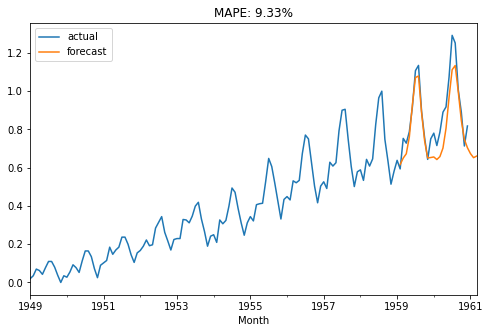

In [11]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

Use the best model obtained over training, according to validation loss:

loading model_best_260.pth.tar


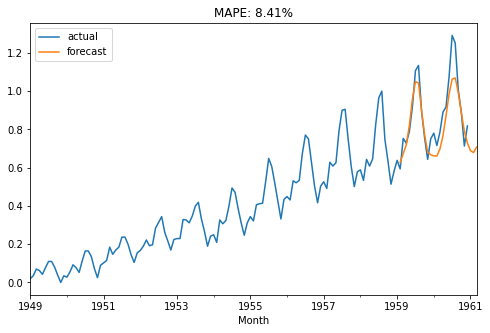

In [12]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

### Backtesting
Let's backtest an `RNN` model, with a forecast horizon of 6 months:

In [17]:
from darts.backtesting import backtest_forecasting

my_model = RNNModel(
    model='RNN',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=32,
    n_epochs=200,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Air_RNN',
    random_state=42
)

# Perform the actual backtest
backtest_series = backtest_forecasting(series_transformed, my_model, pd.Timestamp('19590101'), 
                                       fcast_horizon_n=6, verbose=True)

MAPE: 6.25%


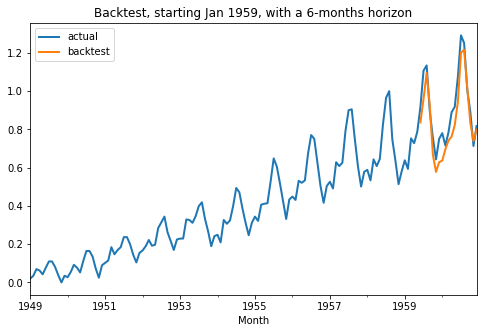

In [18]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, starting Jan 1959, with a 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                 transformer.inverse_transform(backtest_series))))

### Trials with a longer output length

In [19]:
my_model_gru = RNNModel(
    model='GRU',
    output_length=OUTPUT_LEN*4,
    input_length=SEQ_LENGTH,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    batch_size=64,
    n_epochs=1500,
    model_name='Air_GRU_out12',
    log_tensorboard=True,
    random_state=42
)

In [20]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.3346, validation loss: 1.1211Training loss: 0.2161, validation loss: 0.9455Training loss: 0.1545, validation loss: 0.8083Training loss: 0.1380, validation loss: 0.6821Training loss: 0.0791, validation loss: 0.5556Training loss: 0.0637, validation loss: 0.4355Training loss: 0.0521, validation loss: 0.3512Training loss: 0.0492, validation loss: 0.3127Training loss: 0.0545, validation loss: 0.3246Training loss: 0.0481, validation loss: 0.3211Training loss: 0.0475, validation loss: 0.3033Training loss: 0.0492, validation loss: 0.2740Training loss: 0.0467, validation loss: 0.2452Training loss: 0.0421, validation loss: 0.2078Training loss: 0.0326, validation loss: 0.1667Training loss: 0.0279, validation loss: 0.1311Training loss: 0.0239, validation loss: 0.0876Training loss: 0.0248, validation loss: 0.0726Training loss: 0.0235, validation loss: 0.0722Training loss: 0.0217, validation loss: 0.0696Training loss: 0.0217, validation loss: 0.0758Training loss: 0.0208, validation 

Result of training

Test with horizon=28, and feeding predictions

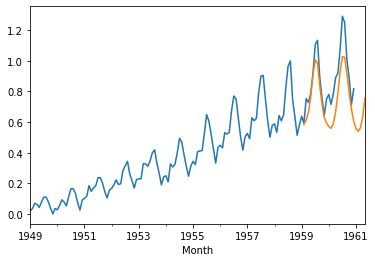

In [21]:
pred_series = my_model_gru.predict(n=28)
series_transformed.plot()
pred_series.plot()

## Monthly sunspot
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

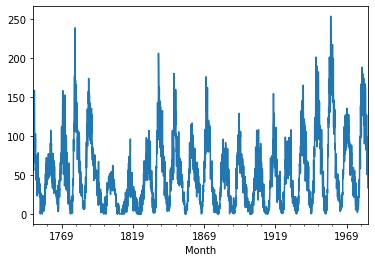

In [22]:
df2 = pd.read_csv('examples/monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', ['Sunspots'])

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

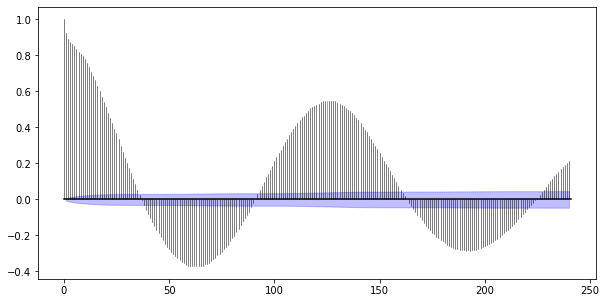

In [23]:
plot_acf(series_sunspot, 125, max_lag=240) # ~11 years seasonality

In [24]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = ScalerWrapper()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer.transform(series_sunspot)

In [25]:
SEQ_LENGTH = 125
HIDDEN_SIZE = 10
OUTPUT_LEN = 10
NUM_LAYERS = 1

In [26]:
my_model_sun = RNNModel(
    model='GRU',
    output_length=OUTPUT_LEN,
    input_length=SEQ_LENGTH,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    batch_size=64,
    n_epochs=300,
    model_name='sun_GRU',
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42
)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

Training loss: 0.1610, validation loss: 0.1911Training loss: 0.0740, validation loss: 0.1329Training loss: 0.0470, validation loss: 0.0987Training loss: 0.0368, validation loss: 0.0821Training loss: 0.0339, validation loss: 0.0753Training loss: 0.0327, validation loss: 0.0720Training loss: 0.0318, validation loss: 0.0686Training loss: 0.0306, validation loss: 0.0648Training loss: 0.0299, validation loss: 0.0601Training loss: 0.0288, validation loss: 0.0576Training loss: 0.0273, validation loss: 0.0514Training loss: 0.0255, validation loss: 0.0446Training loss: 0.0235, validation loss: 0.0376Training loss: 0.0211, validation loss: 0.0307Training loss: 0.0190, validation loss: 0.0269Training loss: 0.0180, validation loss: 0.0254Training loss: 0.0178, validation loss: 0.0246Training loss: 0.0176, validation loss: 0.0243Training loss: 0.0177, validation loss: 0.0236Training loss: 0.0176, validation loss: 0.0233Training loss: 0.0176, validation loss: 0.0235Training loss: 0.0174, validation 

For the sake of comparison, let's also fit an exponential smoothing model:

In [27]:
my_model_ets = ExponentialSmoothing()
my_model_ets.fit(train_sp_transformed)

In [28]:
# Compute the predictions with the two models (the RNN can be somewhat slow)
pred_series = my_model_sun.predict(550)
pred_series_ets = my_model_ets.predict(550)

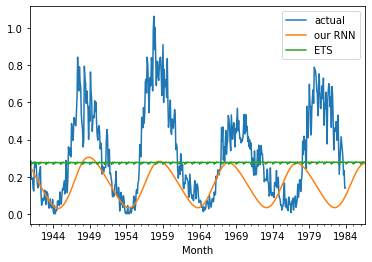

In [29]:
val_sp_transformed.plot(label='actual')
pred_series.plot(label='our RNN')
pred_series_ets.plot(label='ETS')
plt.legend();